In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # another visualization library, does correlation matrix
import sklearn
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
import pydotplus # to print the tree
from IPython.display import Image
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.svm import SVR
import keras
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import cross_val_score, GridSearchCV

# Original, unedited dataset

In [14]:
df = pd.read_csv("NewYork_Airbnb.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [39]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## generate df_nonames

In [15]:
# Drop useless columns
df_nonames = df.drop(["id", "name", "host_id", "host_name", "last_review"], axis = 1)
df_nonames["reviews_per_month"] = df_nonames["reviews_per_month"].fillna(np.mean(df_nonames["reviews_per_month"]))
# keeping the Airbnb name out for now in a copy of the data frame
df_nonames.dropna(inplace = True) # inplace so you don't have to declare a new variable
# df["last_review"].fillna(df["last_review"])
df_nonames.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0


# get df_under500

In [16]:
# Histogram with $500 and less
df_under500 = df_nonames[(df_nonames["price"] <= 500) & (df_nonames["price"] > 25)]
# also filtering out the Airbnbs $25 and under; there are only 218 of those
df_under500

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,1.373221,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,1.373221,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1.373221,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,1.373221,6,2


# Remove Staten Island

In [6]:
len(df_under500[df_under500["neighbourhood_group"] == "Staten Island"])

362

In [5]:
df_under500_inc = df_under500[df_under500["neighbourhood_group"] != "Staten Island"]
df_under500_inc # because it's an incomplete set

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,1.373221,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,1.373221,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1.373221,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,1.373221,6,2


# Original price distribution?

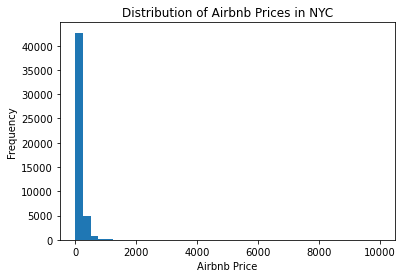

In [27]:
plt.hist(data = df_nonames, x = "price", bins = 40)
plt.title("Distribution of Airbnb Prices in NYC")
plt.xlabel("Airbnb Price")
plt.ylabel("Frequency")
plt.show()

## And after we restricted the Airbnbs to $25 < price <= $500?

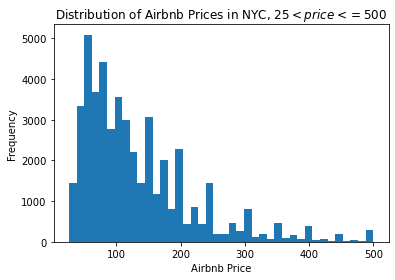

In [29]:
plt.hist(data = df_under500, x = "price", bins = 40)
plt.title("Distribution of Airbnb Prices in NYC, $25 < price <= $500")
plt.xlabel("Airbnb Price")
plt.ylabel("Frequency")
plt.show()

## And after we removed Staten Island??

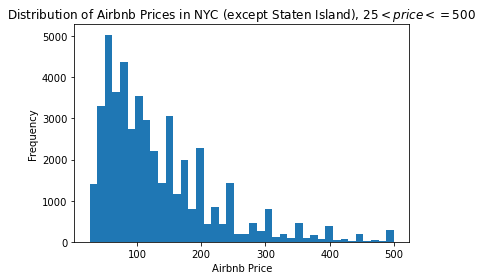

In [34]:
plt.hist(data = df_under500_inc, x = "price", bins = 40)
plt.title("Distribution of Airbnb Prices in NYC (except Staten Island), $25 < price <= $500")
plt.xlabel("Airbnb Price")
plt.ylabel("Frequency")
plt.show()

# Before we impose a price ceiling, we should create a bar graph showing the number of listings in each borough

In [6]:
boroughs = df_nonames["neighbourhood_group"].unique()

In [13]:
boroughs

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

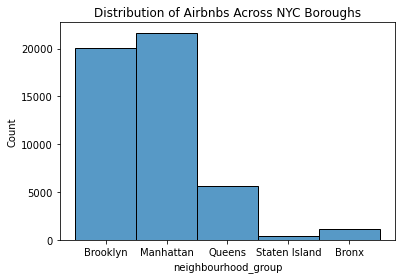

In [18]:
sns.histplot(data = df_nonames, x = "neighbourhood_group")
plt.title("Distribution of Airbnbs Across NYC Boroughs")
plt.show() # gets rid of Text()

In [19]:
len(df_nonames[df_nonames["neighbourhood_group"] == "Staten Island"])

373

## Did the distribution really change after the price was restricted?

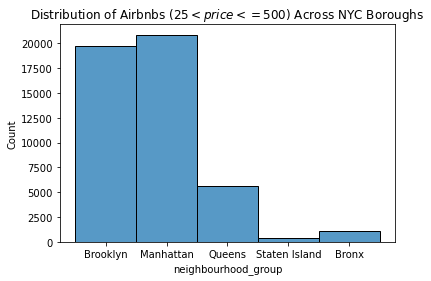

In [30]:
sns.histplot(data = df_under500, x = "neighbourhood_group")
plt.title("Distribution of Airbnbs ($25 < price <= $500) Across NYC Boroughs")
plt.show() # gets rid of Text()

### No, not really.

In [36]:
len(df_under500[df_under500["neighbourhood_group"] == "Staten Island"])

362

# ONE-HOT ENCODING df_under500_inc (without Niche data)

In [139]:
# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under500_inc["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under500_inc["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under500_inc["room_type"], prefix = "room_type")
df_under500_inc.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under500_inc]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
df_oh

,n_group_Bronx,n_group_Brooklyn,n_group_Manhattan,n_group_Queens,neighborhood_Allerton,neighborhood_Arverne,neighborhood_Astoria,neighborhood_Bath Beach,neighborhood_Battery Park City,neighborhood_Bay Ridge,...,room_type_Private room,room_type_Shared room,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,1,0,0,0,0,0,0,0,0,...,1,0,40.64749,-73.97237,149,1,9,0.210000,6,365
1,0,0,1,0,0,0,0,0,0,0,...,0,0,40.75362,-73.98377,225,1,45,0.380000,2,355
2,0,0,1,0,0,0,0,0,0,0,...,1,0,40.80902,-73.94190,150,3,0,1.373221,1,365
3,0,1,0,0,0,0,0,0,0,0,...,0,0,40.68514,-73.95976,89,1,270,4.640000,1,194
4,0,0,1,0,0,0,0,0,0,0,...,0,0,40.79851,-73.94399,80,10,9,0.100000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,0,1,0,0,0,0,0,0,0,0,...,1,0,40.67853,-73.94995,70,2,0,1.373221,2,9
48891,0,1,0,0,0,0,0,0,0,0,...,1,0,40.70184,-73.93317,40,4,0,1.373221,2,36
48892,0,0,1,0,0,0,0,0,0,0,...,0,0,40.81475,-73.94867,115,10,0,1.373221,1,27
48893,0,0,1,0,0,0,0,0,0,0,...,0,1,40.75751,-73.99112,55,1,0,1.373221,6,2


In [ ]:
df_oh

# Data from Niche

In [6]:
niche_data = pd.read_csv("NYC_Niche.csv")

# merge with Niche data (once you obtain it!!!)

In [17]:
df_under500_deluxe = df_under500_inc.merge(niche_data, how = 'inner', left_on = "neighbourhood",
                                       right_on = "Airbnb Neighborhood")
df_under500_deluxe.drop("Airbnb Neighborhood", axis = 1, inplace = True)
# df_under500_deluxe = df_under500_deluxe[df_under500_deluxe["Overall Grade Niche"] != "C-"]
# Drop Airbnbs in neighborhoods rated C- by Niche
df_under500_deluxe.head()

# now go encode this df_under500_deluxe variant; scroll down to find it

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,1551,697061,A+
1,Brooklyn,Kensington,40.64106,-73.97426,Private room,39,1,45,0.46,2,365,1551,697061,A+
2,Brooklyn,Kensington,40.64302,-73.97255,Private room,39,1,82,0.94,2,365,1551,697061,A+
3,Brooklyn,Kensington,40.64277,-73.97296,Private room,60,2,20,0.42,1,347,1551,697061,A+
4,Brooklyn,Kensington,40.64330,-73.97386,Entire home/apt,90,30,3,0.05,1,286,1551,697061,A+


## creating a dictionary for the letter grades

In [18]:
# grade_score = {"A+": 2, "A": 2, "A-": 2, "B+": 1, "B": 1, "B-": 1, "C+": 0, "C": 0, "C-": 0}
grade_score = {"A+": 8, "A": 7, "A-": 6, "B+": 5, "B": 4, "B-": 3, "C+": 2, "C": 1, "C-": 0}
df_under500_deluxe["Overall Grade Niche"] = df_oh["Overall Grade Niche"].replace(grade_score)

In [32]:
df_under500_deluxe

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365,1551,697061,8
1,Brooklyn,Kensington,40.64106,-73.97426,Private room,39,1,45,0.460000,2,365,1551,697061,8
2,Brooklyn,Kensington,40.64302,-73.97255,Private room,39,1,82,0.940000,2,365,1551,697061,8
3,Brooklyn,Kensington,40.64277,-73.97296,Private room,60,2,20,0.420000,1,347,1551,697061,8
4,Brooklyn,Kensington,40.64330,-73.97386,Entire home/apt,90,30,3,0.050000,1,286,1551,697061,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44396,Brooklyn,Mill Basin,40.61768,-73.91669,Entire home/apt,85,2,36,3.260000,1,322,1688,709764,5
44397,Brooklyn,Mill Basin,40.61058,-73.90971,Entire home/apt,299,3,3,2.250000,1,339,1688,709764,5
44398,Queens,Breezy Point,40.56605,-73.86994,Private room,195,1,4,0.350000,2,160,99,583170,6
44399,Queens,Breezy Point,40.56568,-73.87009,Private room,195,1,1,0.090000,2,59,99,583170,6


# encoding df_under500_deluxe

In [10]:
# The neighborhood, borough, and room type will be one-hot encoded

# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under500_deluxe["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under500_deluxe["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under500_deluxe["room_type"], prefix = "room_type")
df_under500_deluxe.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under500_deluxe]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
df_oh

,n_group_Bronx,n_group_Brooklyn,n_group_Manhattan,n_group_Queens,neighborhood_Allerton,neighborhood_Arverne,neighborhood_Astoria,neighborhood_Bath Beach,neighborhood_Battery Park City,neighborhood_Bay Ridge,...,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
0,0,1,0,0,0,0,0,0,0,0,...,-73.97237,149,1,9,0.210000,6,365,1551,697061,A+
1,0,1,0,0,0,0,0,0,0,0,...,-73.97426,39,1,45,0.460000,2,365,1551,697061,A+
2,0,1,0,0,0,0,0,0,0,0,...,-73.97255,39,1,82,0.940000,2,365,1551,697061,A+
3,0,1,0,0,0,0,0,0,0,0,...,-73.97296,60,2,20,0.420000,1,347,1551,697061,A+
4,0,1,0,0,0,0,0,0,0,0,...,-73.97386,90,30,3,0.050000,1,286,1551,697061,A+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44396,0,1,0,0,0,0,0,0,0,0,...,-73.91669,85,2,36,3.260000,1,322,1688,709764,B+
44397,0,1,0,0,0,0,0,0,0,0,...,-73.90971,299,3,3,2.250000,1,339,1688,709764,B+
44398,0,0,0,1,0,0,0,0,0,0,...,-73.86994,195,1,4,0.350000,2,160,99,583170,A-
44399,0,0,0,1,0,0,0,0,0,0,...,-73.87009,195,1,1,0.090000,2,59,99,583170,A-


In [166]:
df_oh

,n_group_Bronx,n_group_Brooklyn,n_group_Manhattan,n_group_Queens,neighborhood_Allerton,neighborhood_Arverne,neighborhood_Astoria,neighborhood_Bath Beach,neighborhood_Battery Park City,neighborhood_Bay Ridge,...,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
0,0,1,0,0,0,0,0,0,0,0,...,-73.97237,149,1,9,0.210000,6,365,1551,697061,8
1,0,1,0,0,0,0,0,0,0,0,...,-73.97426,39,1,45,0.460000,2,365,1551,697061,8
2,0,1,0,0,0,0,0,0,0,0,...,-73.97255,39,1,82,0.940000,2,365,1551,697061,8
3,0,1,0,0,0,0,0,0,0,0,...,-73.97296,60,2,20,0.420000,1,347,1551,697061,8
4,0,1,0,0,0,0,0,0,0,0,...,-73.97386,90,30,3,0.050000,1,286,1551,697061,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44210,0,1,0,0,0,0,0,0,0,0,...,-73.91669,85,2,36,3.260000,1,322,1688,709764,5
44211,0,1,0,0,0,0,0,0,0,0,...,-73.90971,299,3,3,2.250000,1,339,1688,709764,5
44212,0,0,0,1,0,0,0,0,0,0,...,-73.86994,195,1,4,0.350000,2,160,99,583170,6
44213,0,0,0,1,0,0,0,0,0,0,...,-73.87009,195,1,1,0.090000,2,59,99,583170,6


## do we want to drop any features?

In [117]:
df_oh.drop(["Median Rent Price Niche"], axis = 1, inplace = True)

In [10]:
df_oh.drop(["Median Home Price Niche"], axis = 1, inplace = True)

In [11]:
df_oh.drop(["Overall Grade Niche"], axis = 1, inplace = True)

# Standard Scaler and Splitting

In [12]:
y = df_oh["price"]
X_beforescaling = df_oh.drop(["price"], axis = 1 )
scaler = StandardScaler()
X = scaler.fit_transform(X_beforescaling)

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)

(33300, 189)
(11101, 189)


# Correlation Matrix (Airbnb and Niche--including the ordinal-encoded Niche grade)

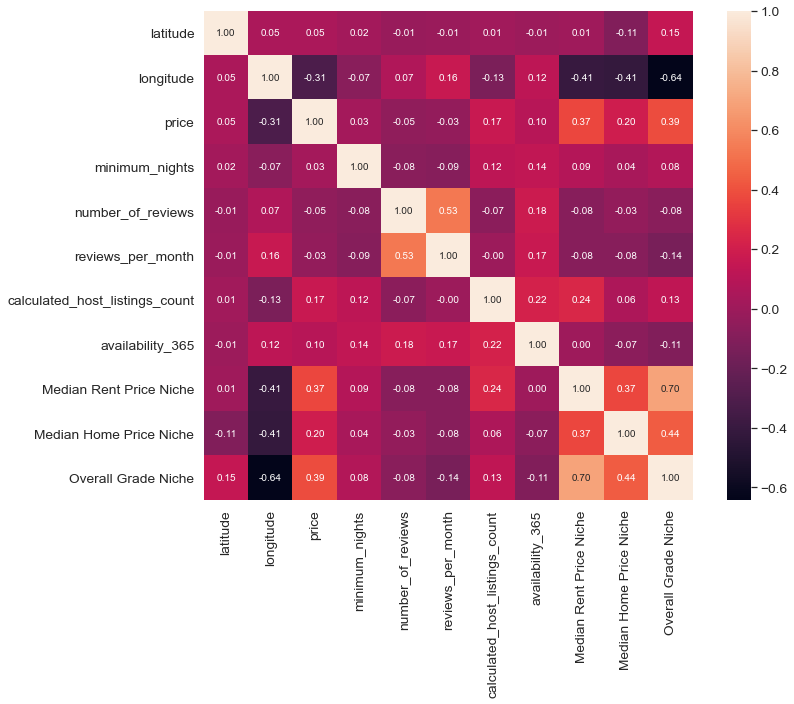

In [19]:
# correlation matrix; will tell us how each variable is related to each other
# will focus on how each variable is related to our target (price)

df_num = df_under500_deluxe.select_dtypes(include = np.number) # only selects numerical columns
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.set(font_scale = 1.25) # set dimension for text
coef = np.corrcoef(df_num.values.T) # calculate correlation coefficient
cols = df_num.columns

sns.heatmap(coef, square = True, cbar = True, annot = True,
            fmt = ".2f", annot_kws = {"size":10},
            xticklabels = cols.values, yticklabels = cols.values)
plt.savefig("CorrMat_Airbnb+Niche.png")

# Correlation Matrix (Airbnb only)

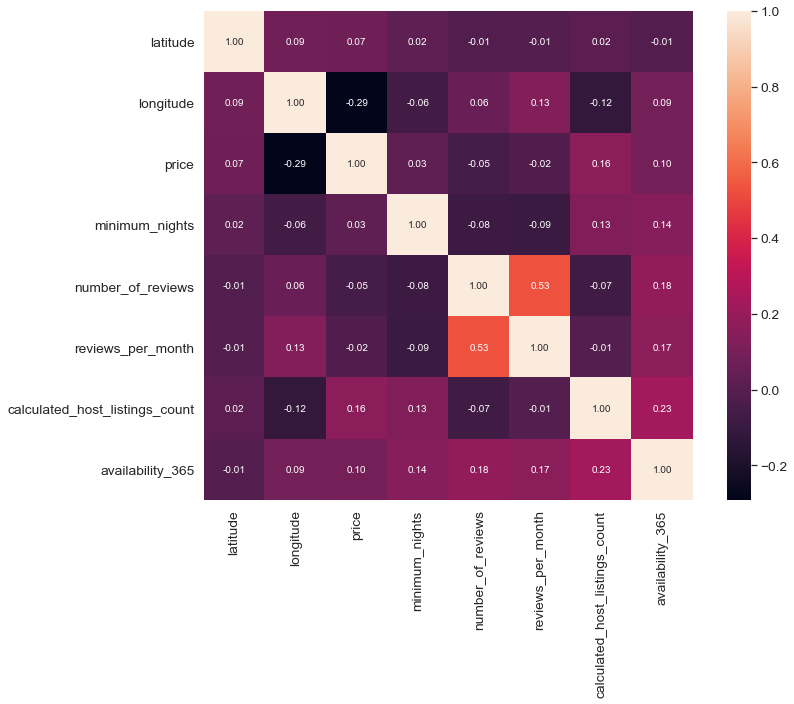

In [34]:
# correlation matrix; will tell us how each variable is related to each other
# will focus on how each variable is related to our target (price)

df_num = df_under500.select_dtypes(include = np.number) # only selects numerical columns
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.set(font_scale = 1.25) # set dimension for text
coef = np.corrcoef(df_num.values.T) # calculate correlation coefficient
cols = df_num.columns

sns.heatmap(coef, square = True, cbar = True, annot = True,
            fmt = ".2f", annot_kws = {"size":10},
            xticklabels = cols.values, yticklabels = cols.values)
plt.savefig("CorrMat_AirbnbOnly.png")

In [ ]:
?sns

# Correlation Matrix (Niche only)

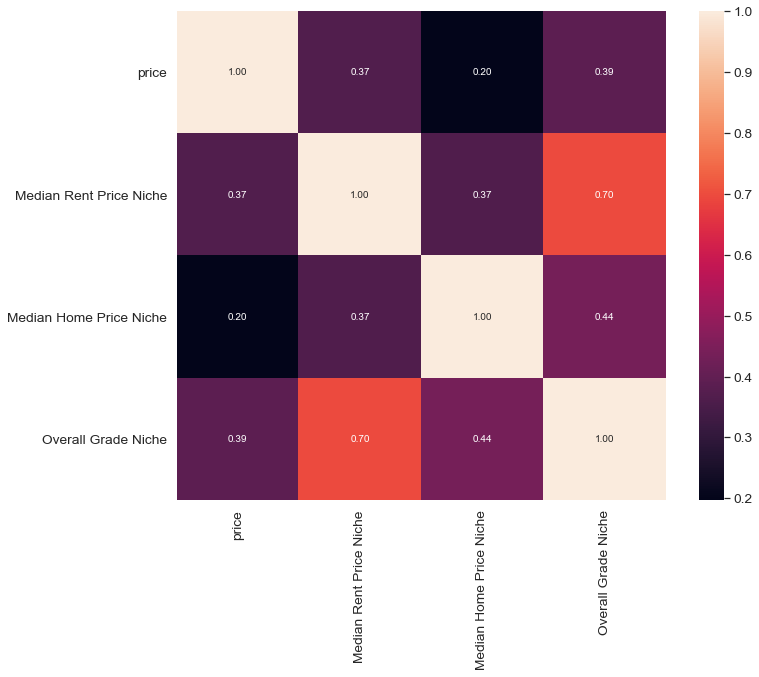

In [35]:
# correlation matrix; will tell us how each variable is related to each other
# will focus on how each variable is related to our target (price)

df_num = df_under500_deluxe[["price", "Median Rent Price Niche", "Median Home Price Niche", "Overall Grade Niche"]] # only selects numerical columns
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.set(font_scale = 1.25) # set dimension for text
coef = np.corrcoef(df_num.values.T) # calculate correlation coefficient
cols = df_num.columns

s = sns.heatmap(coef, square = True, cbar = True, annot = True,
            fmt = ".2f", annot_kws = {"size":10},
            xticklabels = cols.values, yticklabels = cols.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
s.set_yticklabels(s.get_yticklabels(), rotation = 0)
plt.savefig("CorrMat_NicheOnly.png")

# Feature Importance (Airbnb and Niche)

Feature ranking:
1. feature 9 (0.212517)
2. feature 0 (0.166229)
3. feature 1 (0.159086)
4. feature 6 (0.103438)
5. feature 4 (0.078625)
6. feature 3 (0.068407)
7. feature 2 (0.065503)
8. feature 5 (0.059117)
9. feature 8 (0.052949)
10. feature 7 (0.034129)


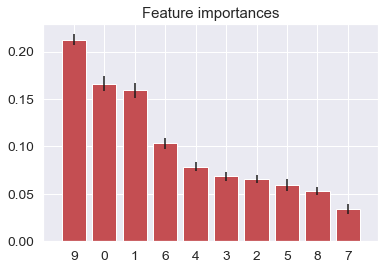

<Figure size 432x288 with 0 Axes>

In [36]:
# Split data
X = np.array(df_under500_deluxe[["latitude", "longitude", "minimum_nights", "number_of_reviews", "reviews_per_month",
                                 "calculated_host_listings_count", "availability_365", "Median Rent Price Niche",
                                 "Median Home Price Niche", "Overall Grade Niche"]])
y = np.array(df_under500_deluxe["price"])


# Build a forest and compute the impurity-based feature importances
forest = RandomForestRegressor(n_estimators=150, max_depth = 16, random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_ # Rank features in X in order of importance for determining y (price)
# feature 0 = latitude
# feature 1 = longitude
# feature 2 = minimum_nights
# feature 3 = number_of_reviews
# feature 4 = reviews_per_month
# feature 5 = calculated_host_listings_count
# feature 6 = availability_365
# feature 7 = Median Rent Price Niche
# feature 8 = Median Home Price Niche
# feature 9 = Overall Grade Niche

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
plt.savefig("FeatImp_Airbnb+Niche")

# Feature Importance (Airbnb only)

Feature ranking:
1. feature 1 (0.354505)
2. feature 0 (0.254453)
3. feature 6 (0.114077)
4. feature 4 (0.081231)
5. feature 3 (0.070985)
6. feature 2 (0.066742)
7. feature 5 (0.058006)


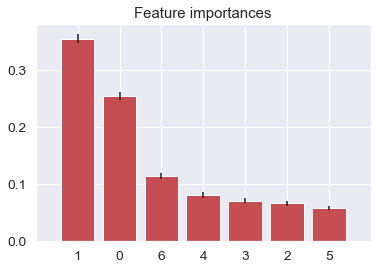

<Figure size 432x288 with 0 Axes>

In [29]:
# Split data
X = np.array(df_under500_deluxe[["latitude", "longitude", "minimum_nights", "number_of_reviews", "reviews_per_month",
            "calculated_host_listings_count", "availability_365"]])
y = np.array(df_under500_deluxe["price"])


# Build a forest and compute the impurity-based feature importances
forest = RandomForestRegressor(n_estimators=150, max_depth = 16, random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_ # Rank features in X in order of importance for determining y (price)
# feature 0 = latitude
# feature 1 = longitude
# feature 2 = minimum_nights
# feature 3 = number_of_reviews
# feature 4 = reviews_per_month
# feature 5 = calculated_host_listings_count
# feature 6 = availability_365

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
plt.savefig("FeatImp_AirbnbOnly")

# Feature Importance (Niche Only)

Feature ranking:
1. feature 2 (0.662840)
2. feature 1 (0.193717)
3. feature 0 (0.143444)


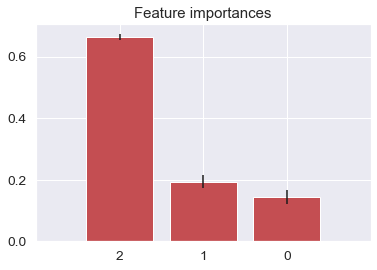

<Figure size 432x288 with 0 Axes>

In [37]:
# Split data
X = np.array(df_under500_deluxe[["Median Rent Price Niche", "Median Home Price Niche", "Overall Grade Niche"]])
y = np.array(df_under500_deluxe["price"])


# Build a forest and compute the impurity-based feature importances
forest = RandomForestRegressor(n_estimators=150, max_depth = 16, random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_ # Rank features in X in order of importance for determining y (price)
# feature 0 = Median Rent Price Niche
# feature 1 = Median Home Price Niche
# feature 2 = Overall Grade Niche

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
plt.savefig("FeatImp_NicheOnly")